# Food-101: Entrenamiento v2.1

In [3]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES_TO_USE = 5
AUTOTUNE = tf.data.AUTOTUNE

if NUM_CLASSES_TO_USE <= 10:
    EPOCHS = 15
elif NUM_CLASSES_TO_USE <= 20:
    EPOCHS = 15
elif NUM_CLASSES_TO_USE <= 50:
    EPOCHS = 20
else:
    EPOCHS = 25

print(f'Clases: {NUM_CLASSES_TO_USE}')
print(f'Épocas: {EPOCHS}')
print(f'Batch size: {BATCH_SIZE}')

Clases: 5
Épocas: 15
Batch size: 32


### 1. Cargar datos y crear pipeline

In [5]:
(train_ds, val_ds), info = tfds.load(
    'food101',
    split=['train', 'validation'],
    with_info=True,
    as_supervised=True
)

class_names = info.features['label'].names
print(f'Dataset completo: {len(class_names)} clases')

if NUM_CLASSES_TO_USE < 101:
    train_ds = train_ds.filter(lambda img, label: label < NUM_CLASSES_TO_USE)
    val_ds = val_ds.filter(lambda img, label: label < NUM_CLASSES_TO_USE)
    num_classes = NUM_CLASSES_TO_USE
    class_names = class_names[:NUM_CLASSES_TO_USE]
    print(f'Clases: {class_names}')
else:
    num_classes = len(class_names)

print(f'\nTotal clases: {num_classes}')

Dataset completo: 101 clases
Clases: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

Total clases: 5


In [6]:
def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image, label

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def augment(image, label):
    image = data_augmentation(image, training=True)
    return image, label

In [7]:
train_dataset = (
    train_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_dataset = (
    val_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [8]:
for images, labels in train_dataset.take(1):
    print(f'Batch imagenes: {images.shape}')
    print(f'Batch labels: {labels.shape}')
    print(f'Rango valores: [{tf.reduce_min(images):.2f}, {tf.reduce_max(images):.2f}]')

Batch imagenes: (32, 224, 224, 3)
Batch labels: (32,)
Rango valores: [0.00, 1.00]


### 2. Crear modelo SIMPLIFICADO

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),
    
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),
    
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

total_params = model.count_params()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,405 (431.27 KB)

 Trainable params: 110,405 (431.27 KB)

 Non-trainable params: 0 (0.00 B)

### 3. Compilar y entrenar

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/15
    118/Unknown 52s 330ms/step - accuracy: 0.2257 - loss: 1.5998

/opt/homebrew/anaconda3/envs/ml_env/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


118/118 ━━━━━━━━━━━━━━━━━━━━ 65s 442ms/step - accuracy: 0.2260 - loss: 1.5994 - val_accuracy: 0.3752 - val_loss: 1.4060
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 37s 305ms/step - accuracy: 0.3181 - loss: 1.4961 - val_accuracy: 0.4272 - val_loss: 1.3509
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 37s 310ms/step - accuracy: 0.4168 - loss: 1.3999 - val_accuracy: 0.4368 - val_loss: 1.4498
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 37s 307ms/step - accuracy: 0.4386 - loss: 1.3519 - val_accuracy: 0.4896 - val_loss: 1.2025
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 37s 309ms/step - accuracy: 0.4672 - loss: 1.2939 - val_accuracy: 0.5112 - val_loss: 1.1746
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 42s 347ms/step - accuracy: 0.4610 - loss: 1.3329 - val_accuracy: 0.4776 - val_loss: 1.2617
Epoch 7/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 46s 356ms/step - accuracy: 0.4734 - loss: 1.3054 - val_accuracy: 0.5376 - val_loss: 1.1396
Epoch 8/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 38s 316ms/step - accuracy: 0.4679 - loss: 1.3274 - val

## 4. Visualizar entrenamiento

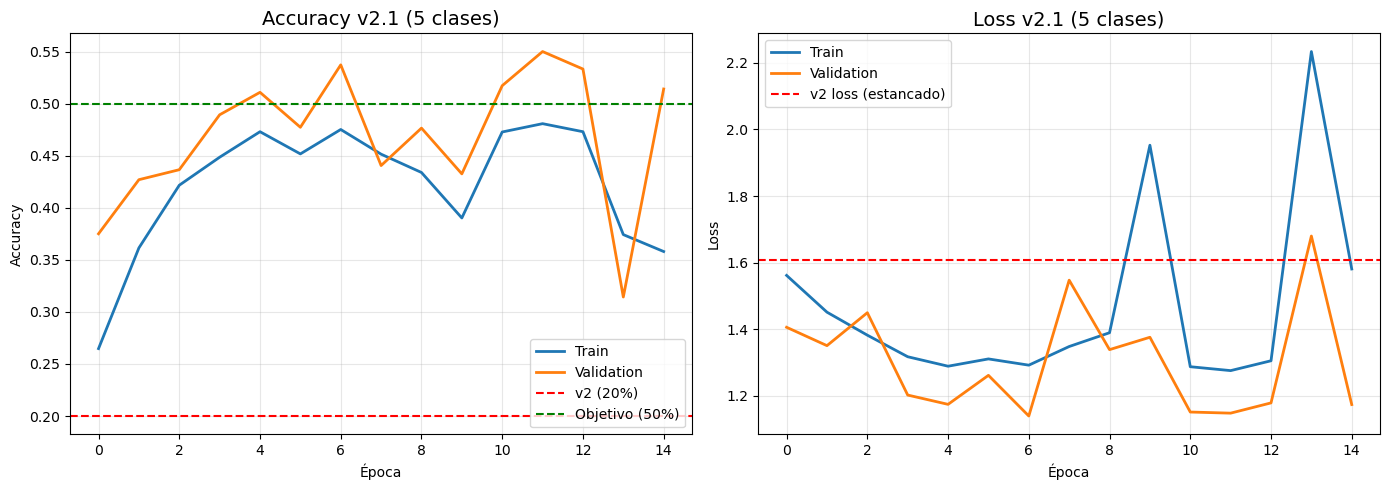


Accuracy final: 51.4%
Loss final: 1.1740

EXITO: Objetivo >50% accuracy alcanzado


In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
ax1.axhline(y=0.2, color='r', linestyle='--', label='v2 (20%)')
ax1.axhline(y=0.5, color='g', linestyle='--', label='Objetivo (50%)')
ax1.set_title(f'Accuracy v2.1 ({NUM_CLASSES_TO_USE} clases)', fontsize=14)
ax1.set_xlabel('Época')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['loss'], label='Train', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
ax2.axhline(y=1.6094, color='r', linestyle='--', label='v2 loss (estancado)')
ax2.set_title(f'Loss v2.1 ({NUM_CLASSES_TO_USE} clases)', fontsize=14)
ax2.set_xlabel('Época')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_acc = history.history['val_accuracy'][-1]
final_loss = history.history['val_loss'][-1]
print(f'\nAccuracy final: {final_acc*100:.1f}%')
print(f'Loss final: {final_loss:.4f}')
if final_acc > 0.5:
    print('\nEXITO: Objetivo >50% accuracy alcanzado')
else:
    print('\nAUN BAJO: Objetivo era >50% accuracy')

## 5. Evaluar modelo

In [22]:
test_loss, test_acc = model.evaluate(val_dataset)
print(f'\nValidation Loss: {test_loss:.4f}')
print(f'Validation Accuracy: {test_acc:.4f}')
print(f'\nMejora sobre random: {test_acc / (1/num_classes):.1f}x')
print(f'Mejora sobre v2: {test_acc / 0.20:.1f}x')

print('\n--- COMPARACIÓN ---')
print(f'v2 (original):  20.0% accuracy (26M params)')
print(f'v2.1 (simple):  {test_acc*100:.1f}% accuracy ({total_params:,} params)')
print(f'\nMejora: {(test_acc - 0.20) / 0.20 * 100:+.0f}% relativo')

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5413 - loss: 1.1314

Validation Loss: 1.1740
Validation Accuracy: 0.5144

Mejora sobre random: 2.6x
Mejora sobre v2: 2.6x

--- COMPARACIÓN ---
v2 (original):  20.0% accuracy (26M params)
v2.1 (simple):  51.4% accuracy (110,405 params)

Mejora: +157% relativo


/opt/homebrew/anaconda3/envs/ml_env/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [23]:
y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(f'Predicciones generadas: {len(y_pred)}')

Predicciones generadas: 1250


### 6. Confusion Matrix

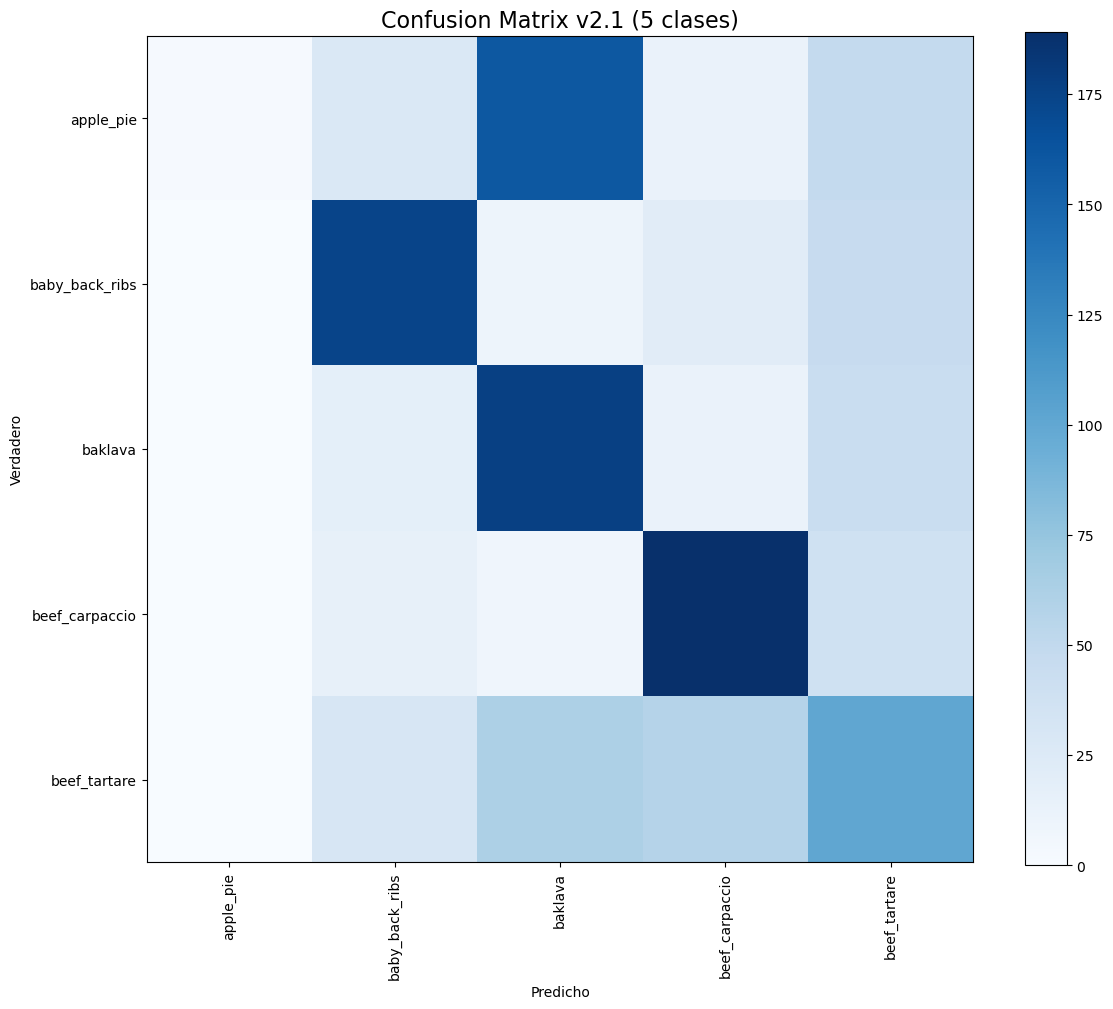

Diagonal (correctas): 643 / 1250 (51.4%)

Predicciones distribuidas en 5 clases (vs 1 en v2)


In [24]:
display_n = num_classes if num_classes <= 20 else 20
mask = (y_true < display_n) & (y_pred < display_n)
y_true_display = y_true[mask]
y_pred_display = y_pred[mask]

cm = confusion_matrix(y_true_display, y_pred_display, labels=range(display_n))

plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title(f'Confusion Matrix v2.1 ({display_n} clases)', fontsize=16)
plt.colorbar()
tick_marks = np.arange(display_n)
plt.xticks(tick_marks, [class_names[i][:15] for i in range(display_n)], rotation=90)
plt.yticks(tick_marks, [class_names[i][:15] for i in range(display_n)])
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

diagonal_sum = np.diag(cm).sum()
total_sum = cm.sum()
print(f'Diagonal (correctas): {diagonal_sum} / {total_sum} ({diagonal_sum/total_sum*100:.1f}%)')
print(f'\nPredicciones distribuidas en {np.count_nonzero(cm.sum(axis=0))} clases (vs 1 en v2)')

In [25]:
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=3
)

print(report)

                precision    recall  f1-score   support

     apple_pie      1.000     0.008     0.016       250
baby_back_ribs      0.659     0.696     0.677       250
       baklava      0.425     0.708     0.532       250
beef_carpaccio      0.649     0.756     0.699       250
  beef_tartare      0.365     0.404     0.383       250

      accuracy                          0.514      1250
     macro avg      0.620     0.514     0.461      1250
  weighted avg      0.620     0.514     0.461      1250



## 7. Visualizar predicciones

In [26]:
sample_images = []
sample_labels = []
sample_predictions = []

for images, labels in val_dataset.take(3):
    predictions = model.predict(images, verbose=0)
    sample_images.extend(images.numpy())
    sample_labels.extend(labels.numpy())
    sample_predictions.extend(np.argmax(predictions, axis=1))

correct_indices = [i for i in range(len(sample_labels)) if sample_labels[i] == sample_predictions[i]]
incorrect_indices = [i for i in range(len(sample_labels)) if sample_labels[i] != sample_predictions[i]]

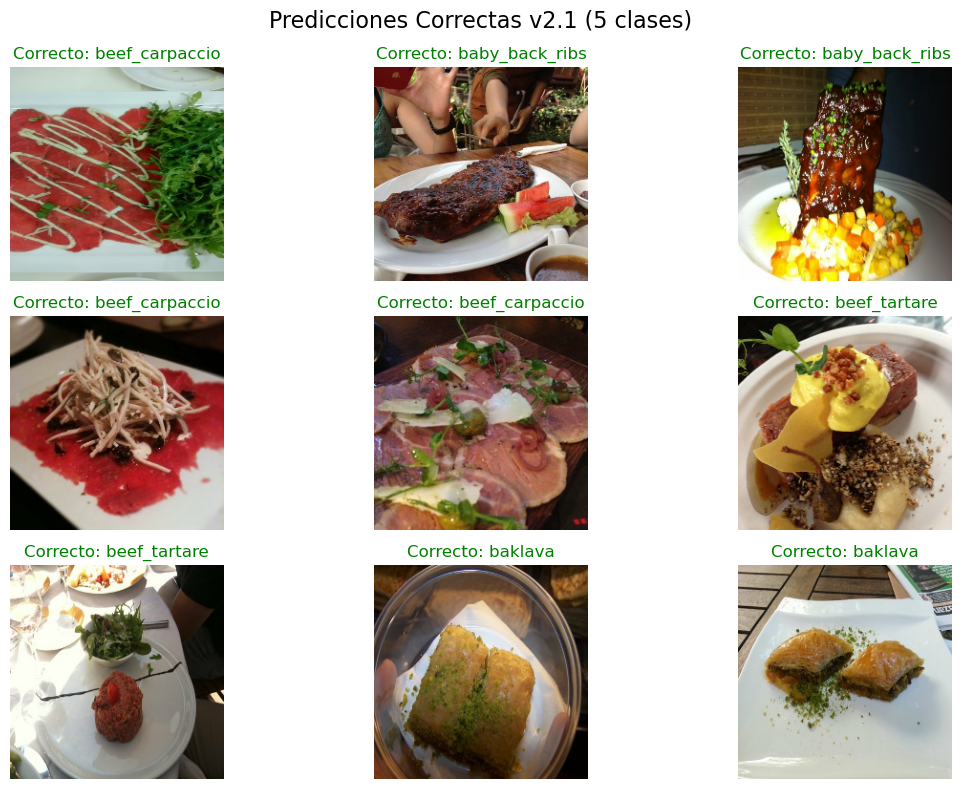

In [27]:
if len(correct_indices) > 0:
    plt.figure(figsize=(12, 8))
    for i in range(min(9, len(correct_indices))):
        idx = correct_indices[i]
        plt.subplot(3, 3, i + 1)
        plt.imshow(sample_images[idx])
        plt.title(f'Correcto: {class_names[sample_labels[idx]][:15]}', color='green')
        plt.axis('off')
    plt.suptitle(f'Predicciones Correctas v2.1 ({NUM_CLASSES_TO_USE} clases)', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print('No hay predicciones correctas en la muestra')

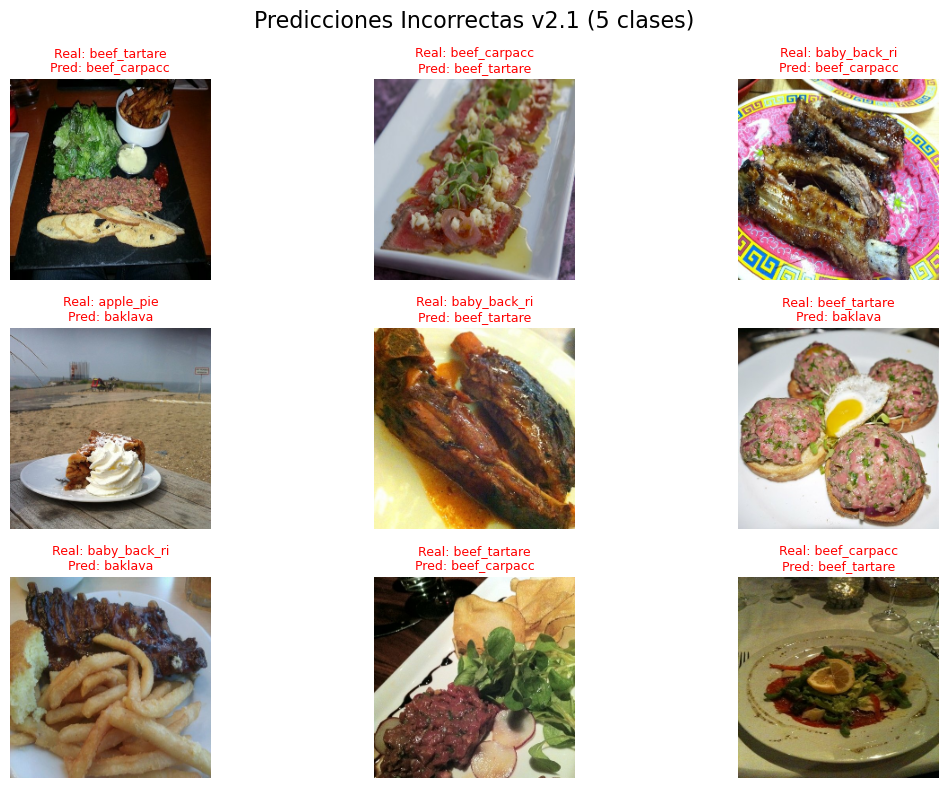

In [28]:
if len(incorrect_indices) > 0:
    plt.figure(figsize=(12, 8))
    for i in range(min(9, len(incorrect_indices))):
        idx = incorrect_indices[i]
        plt.subplot(3, 3, i + 1)
        plt.imshow(sample_images[idx])
        plt.title(f'Real: {class_names[sample_labels[idx]][:12]}\nPred: {class_names[sample_predictions[idx]][:12]}',
                  fontsize=9, color='red')
        plt.axis('off')
    plt.suptitle(f'Predicciones Incorrectas v2.1 ({NUM_CLASSES_TO_USE} clases)', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print('¡Todas las predicciones son correctas!')

## 9. Resumen final

In [29]:
print(f'\nRESULTADOS ({num_classes} clases, {EPOCHS} épocas):')
print(f'  - Training Accuracy:   {history.history["accuracy"][-1]:.4f}')
print(f'  - Validation Accuracy: {test_acc:.4f}')
print(f'  - Training Loss:       {history.history["loss"][-1]:.4f}')
print(f'  - Validation Loss:     {test_loss:.4f}')
print(f'\nCOMPARACIÓN:')
print(f'  - v2 (original):  20.0% accuracy, 26M params')
print(f'  - v2.1 (simple):  {test_acc*100:.1f}% accuracy, {total_params:,} params')
print(f'  - Mejora:         {(test_acc - 0.20) / 0.20 * 100:+.0f}% relativo')
if test_acc > 0.5:
    print(f'\nOBJETIVO: ALCANZADO (meta: >50%)')
else:
    print(f'\nOBJETIVO: NO ALCANZADO (meta: >50%)')



RESULTADOS (5 clases, 15 épocas):
  - Training Accuracy:   0.3581
  - Validation Accuracy: 0.5144
  - Training Loss:       1.5811
  - Validation Loss:     1.1740

COMPARACIÓN:
  - v2 (original):  20.0% accuracy, 26M params
  - v2.1 (simple):  51.4% accuracy, 110,405 params
  - Mejora:         +157% relativo

OBJETIVO: ALCANZADO (meta: >50%)
